# Women's voices before and after #MeToo

## Introduction
In this project, we will use the [Quotebank dataset](#https://dl.acm.org/doi/pdf/10.1145/3437963.3441760), an open corpus of 178 million quotations attributed to the speakers who uttered them, extracted from 162 million English news articles published between 2008 and 2020. We will here restrict our analysis to articles published between 2015 and 2020.


## Preprocessing
We are provided with one dataset per year, which are pretty large (from 792,3Mo to 4,84Go). The datasets provided to us follow the pattern below: 

```
root
 |-- quoteID: string 
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- date: string 
 |-- numOccurrences: int
 |-- probas: list
 |-- urls: list
 |-- phase: string 
```

1. Since our analysis will be based on the difference between male and female speakers, we need to keep only the quotations for which the speakers are known. We therefore dropped the quotations for which the speaker is unknown, and made the choice to keep only the quotations for which the probability that it is the correct speaker is greater than 0.7.


2. To further reduce the datasets, we removed columns of no interest to our analysis: urls, probas, phase and quoteID. We splitted the dataset of 2017 in two: January-October (date of the emergence of the movement) and October-December. After that, we removed the date, still only knowing the year of the dataset will be enough for our analysis. Steps 1 and 2 were performed using Google colab. 
The code for these two first steps is available [here](src/Reduce_data.ipynb).


3. Next, in order to have useful information about the speakers, we used additional speaker metadata available for ~9M unique Wikidata entities (identified by their QID) in the form of a .parquet file named speaker_attributes.parquet. We decided to keep the following attributes: 'gender', 'date_of_birth', 'occupation', 'id', 'ethnic_group', 'academic_degree', 'occupation' and 'religion'. For each dataset, we computed the current age of the speaker the year of the quotation, and thus transformed the column 'date_of_birth' by a column 'age'. Thus, after merging, the datasets follow the following pattern:
```
root
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- numOccurrences: int
 |-- gender: ndarray
 |-- age: int
 |-- occupation: ndarray
 |-- ethnic_group: ndarray
 |-- academic_degree: ndarray
 |-- religion: ndarray
```


4. Then, we dropped the quotations for which the gender is not known, since we will build all our analyses on it. We then replaced all the wikicodes in the dataset with readable information, using a [dictionnary](data/wikidata_labels_descriptions_quotebank.csv.bz2) linking wikidata labels and descriptions. The speakers for which the year of birth is not known are also removed. 

The code for step 3 and 4 is available [here](src/get_attributes.ipynb)

5. The datasets are now reduced. In order to compute some primary descriptive tasks, we took only samples of this reduced datasets. In particular, we took 100'000 quotations per year. 

## Imports

In [1]:
import pandas as pd
import bz2
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import quotes_by_gender, unique_speaker_per_gender
from collections import Counter

## Datasets

In [2]:
DATA_FOLDER = 'data/'


DATA_2015 = DATA_FOLDER+"sample-2015.json.bz2"
DATA_2016 = DATA_FOLDER+"sample-2016.json.bz2"
DATA_2017_BEFORE = DATA_FOLDER + "sample-2017-before.json.bz2"
DATA_2017_AFTER = DATA_FOLDER + "sample-2017-after.json.bz2"
DATA_2018 = DATA_FOLDER+"sample-2018.json.bz2"
DATA_2019 = DATA_FOLDER+"sample-2019.json.bz2"
DATA_2020 = DATA_FOLDER+"sample-2020.json.bz2"


## Wikidata attributes and dictionnary

In [3]:
WIKIDATA_LABELS = DATA_FOLDER + "wikidata_labels_descriptions_quotebank.csv.bz2"
SPEAKER_ATTRIBUTES_DATA = DATA_FOLDER+"speaker_attributes.parquet"

Load the data:

In [4]:
wiki_labels = pd.read_csv(WIKIDATA_LABELS, compression='bz2', index_col='QID')

In [5]:
quotes_2015 = pd.read_json(DATA_2015)
quotes_2016 = pd.read_json(DATA_2016)
quotes_2017_before = pd.read_json(DATA_2017_BEFORE)
quotes_2017_after = pd.read_json(DATA_2017_AFTER)
quotes_2018 = pd.read_json(DATA_2018)
quotes_2019 = pd.read_json(DATA_2019)
quotes_2020 = pd.read_json(DATA_2020)

In [6]:
quotes_2017 = pd.concat([quotes_2017_before, quotes_2017_after])

In [7]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
quotes_years = [quotes_2015, quotes_2016, quotes_2017, quotes_2018, quotes_2019, quotes_2020]

In [8]:
years_detailed = [2015, 2016, 2017, 2017, 2018, 2019, 2020]
period_detailed = ['Before #MeToo', 'Before #MeToo', 'Before #MeToo',
                   'After #MeToo (short term)', 'After #MeToo (short term)', 
                   'After #MeToo (long term)','After #MeToo (long term)']
quotes_years_detailed= [quotes_2015, quotes_2016, quotes_2017_before, quotes_2017_after, 
                        quotes_2018, quotes_2019, quotes_2020]

In [9]:
for i in range(len(quotes_years_detailed)):
    quotes_years_detailed[i]['year']=years_detailed[i]
    quotes_years_detailed[i]['period']=period_detailed[i]

In [10]:
quotes_all = pd.concat(quotes_years_detailed, ignore_index=True)

In [11]:
quotes_before = pd.concat([quotes_2015, quotes_2016, quotes_2017_before], ignore_index=True)
quotes_after_shortterm = pd.concat([quotes_2017_after, quotes_2018], ignore_index=True)
quotes_after_longterm = pd.concat([quotes_2019, quotes_2020], ignore_index=True)
quotes_after = pd.concat([quotes_after_shortterm, quotes_after_longterm], ignore_index=True)

In [12]:
periods = ['Before #MeToo', 'After #MeToo (short term)', 'After #MeToo (long term)']
quotes_periods = [quotes_before, quotes_after_shortterm, quotes_after_longterm]

In [13]:
quotes_before.head()

,quotation,speaker,qids,numOccurrences,gender,age,occupation,ethnic_group,academic_degree,religion,year,period
0,"Once you're at Triple-A, you're an injury away...",Theo Epstein,Q1057736,1,male,42,"[executive, president, businessperson]",None,None,None,2015,Before #MeToo
1,This enhances the interaction between the ligh...,David Hunger,Q42419043,1,male,38,[researcher],None,None,None,2015,Before #MeToo
2,These events certainly do help Hong Kong to ma...,Allan Zeman,Q2837795,1,male,66,"[fashion designer, justice of the peace, busin...",None,None,None,2015,Before #MeToo
3,One of the joys of living in Corpus Christi is...,Craig Henderson,Q1138558,1,male,28,[association football player],None,None,None,2015,Before #MeToo
4,"We must deduct points, relegate a team [ to a ...",Sepp Blatter,Q483437,33,male,79,"[sports official, economist, politician, ice h...",[Swiss],None,None,2015,Before #MeToo


# Gender representations in the news
## Number of quotations by gender from 2015 to 2020

In [14]:
by_gender_years = []
for year, quotes in zip(years, quotes_years):
    by_gender_years.append(quotes_by_gender(quotes, year, major_only = False, others_grouped = True))

quotes_by_gender_years = pd.concat(by_gender_years, ignore_index = True)

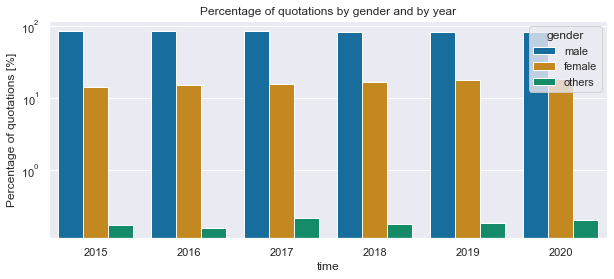

In [15]:
sns.set(rc = {'figure.figsize':(10,4)})
sns.set_palette('colorblind')

ax = sns.barplot(x = quotes_by_gender_years['time'], y = quotes_by_gender_years['count']*100, hue = quotes_by_gender_years['gender'], data = quotes_by_gender_years)
ax.set(yscale="log");
ax.set(ylabel='Percentage of quotations [%]')
ax.set_title('Percentage of quotations by gender and by year');

**Be careful, this plot has log scale in y-axis.**

By plotting the percentage of quotes by gender for every year from 2015 to 2020, we clearly see that the 'male' gender is the most represented and is the one for which most of the quotes are related.
We can also see the proportion of speakers having a different gender than 'male' or 'female' is really low. For this reason, and since our analysis will mainly focus of the 'female' gender and its differences with the 'male' gender, we will discard these speakers for further analysis.

In [16]:
#Drop the rows having a gender other than the 2 most represented
for year, quotes in zip(years, quotes_years):
    quotes.drop(quotes[
        quotes['gender'].isin(quotes_by_gender(quotes, major_only = True)['gender']) == False].index, inplace = True)

In [17]:
for period, quotes in zip(periods, quotes_periods):
    quotes.drop(quotes[
        quotes['gender'].isin(quotes_by_gender(quotes, major_only = True)['gender']) == False].index, inplace = True)

Let's look at the percentage of quotations by gender for every year, now that we have only 'male' and 'female' genders.

In [18]:
by_gender_years = []
for year, quotes in zip(years, quotes_years):
    by_gender_years.append(quotes_by_gender(quotes, year, major_only = True))

quotes_by_gender_years = pd.concat(by_gender_years, ignore_index = True)

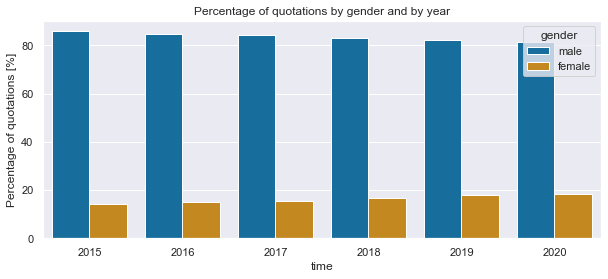

In [19]:
sns.set(rc = {'figure.figsize':(10,4)})
sns.set_palette('colorblind')

ax = sns.barplot(x = quotes_by_gender_years['time'], y = quotes_by_gender_years['count']*100, hue = quotes_by_gender_years['gender'], data = quotes_by_gender_years)
ax.set(ylabel='Percentage of quotations [%]')
ax.set_title('Percentage of quotations by gender and by year');

Looking at this plot, we observe a clear difference between male and female percentage of quotations. Indeed, around 80% of all reported quotations are told by males. However, looking at the females, we can observe a little increase of their percentage of quotations during time. 

Let's now take a look a little bit closer at the impact of the #MeToo movement by separating time into 3 categories:

-before #MeToo: from January 2015 to October 2017

-after #MeToo (short term): from October 2017 to December 2018

-after #MeToo (longterm): from January 2019 to December 2020


In [20]:
by_gender_periods = []
for period, quotes in zip(periods, quotes_periods):
    by_gender_periods.append(quotes_by_gender(quotes, period, major_only = True))

quotes_by_gender_periods = pd.concat(by_gender_periods, ignore_index = True)

In [21]:
quotes_by_gender_periods

,gender,count,Occurrences,time
0,male,0.850526,0.847414,Before #MeToo
1,female,0.149474,0.152586,Before #MeToo
2,male,0.838579,0.839697,After #MeToo (short term)
3,female,0.161421,0.160303,After #MeToo (short term)
4,male,0.818454,0.814626,After #MeToo (long term)
5,female,0.181546,0.185374,After #MeToo (long term)


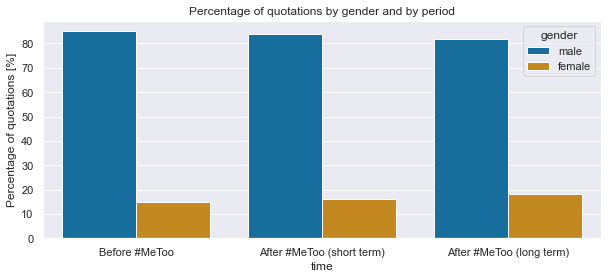

In [22]:
ax = sns.barplot(x = quotes_by_gender_periods['time'], y = quotes_by_gender_periods['count']*100, hue = quotes_by_gender_periods['gender'], data = quotes_by_gender_periods)
#ax.set(yscale="log");
ax.set(ylabel='Percentage of quotations [%]')
ax.set_title('Percentage of quotations by gender and by period');

Here again we can observe a little increase in the percentage of female quotations: before the movement the percentage was around 15%, and it lies around 18% long after the movement.

## Number of occurences by gender from 2015 to 2020

In the previous part, we focused on the number of unique quotation per gender. We will now explore the total number of occurrences per gender to see if we observe any difference.

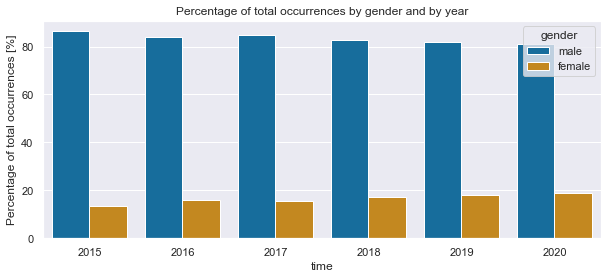

In [23]:
ax = sns.barplot(x = quotes_by_gender_years['time'], y = quotes_by_gender_years['Occurrences']*100, hue = quotes_by_gender_years['gender'], data = quotes_by_gender_years)
ax.set(ylabel='Percentage of total occurrences [%]')
ax.set_title('Percentage of total occurrences by gender and by year');

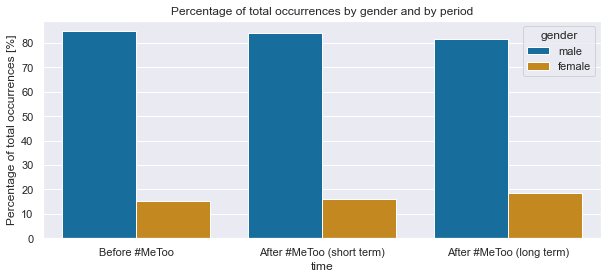

In [24]:
ax = sns.barplot(x = quotes_by_gender_periods['time'], y = quotes_by_gender_periods['Occurrences']*100, hue = quotes_by_gender_periods['gender'], data = quotes_by_gender_periods)
ax.set(ylabel='Percentage of total occurrences [%]')
ax.set_title('Percentage of total occurrences by gender and by period');

We see that these graphs are sensibly the same than the above ones. Taking the number of unique quotes or the total number of occurences per gender lead to the same proportions.

## Number of speakers by gender from 2015 to 2020

Previously, we have looked at the proportions of unique quotations by gender, as well as the proportion of total occurences attributed to each gender. In this last part, let's take a look at the proportion of unique speakers of each gender over the time.

In [25]:
by_speaker_years = []
for year, quotes in zip(years, quotes_years):
    by_speaker_years.append(unique_speaker_per_gender(quotes, year))

quotes_by_speaker_years = pd.concat(by_speaker_years, ignore_index = True)

In [26]:
quotes_by_speaker_years

,gender,count,time
0,male,0.829249,2015
1,female,0.170751,2015
2,male,0.821708,2016
3,female,0.178292,2016
4,male,0.810816,2017
5,female,0.189184,2017
6,male,0.808158,2018
7,female,0.191842,2018
8,male,0.801912,2019
9,female,0.198088,2019


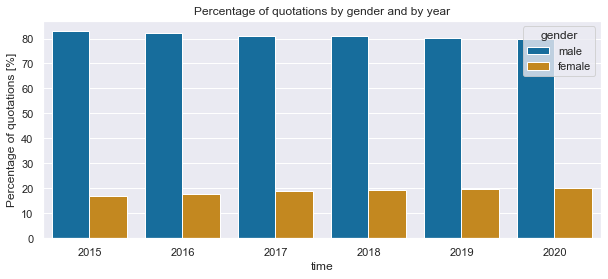

In [27]:
ax = sns.barplot(x = quotes_by_speaker_years['time'], y = quotes_by_speaker_years['count']*100, hue = quotes_by_speaker_years['gender'], data = quotes_by_speaker_years)
ax.set(ylabel='Percentage of quotations [%]')
ax.set_title('Percentage of quotations by gender and by year');

Here again, we can see that the proportion of male speakers is largely bigger than female speakers since they represent 80% of all speakers. However, in this plot we observe a linear increase of female speakers over the years from 2015 to 2020. Particularly, in 2020, the proportion of female speaker hits the 20%. It was not the case when looking at the graph of occurences and quotations: it seems that a unique male speaker has more quotations and occurences attributed to him than does a female speaker.

In [28]:
by_speaker_periods = []
for period, quotes in zip(periods, quotes_years):
    by_speaker_periods.append(unique_speaker_per_gender(quotes, period))

quotes_by_speaker_periods = pd.concat(by_speaker_periods, ignore_index = True)

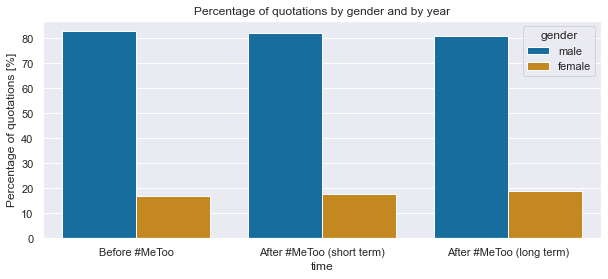

In [29]:
ax = sns.barplot(x = quotes_by_speaker_periods['time'], y = quotes_by_speaker_periods['count']*100, hue = quotes_by_speaker_periods['gender'], data = quotes_by_speaker_periods)
ax.set(ylabel='Percentage of quotations [%]')
ax.set_title('Percentage of quotations by gender and by year');

Looking at this plot, we can see the same trend than above: it seems to be a little bit more female speakers compared to male speaker as time increase. However, we do not know for now if it is really related to the #MeToo movement or by an overall mentality change.

## Lexical fields

Four different lexical fields are chosen and compared with the data. One is concerning the terms "woman", one for the "man" and the two left for the "wife" and "husband". This study could allow us to understand better the description and adjectives used to describe men and women in the newspapers.

In [30]:
chp_lex_woman = [' woman ', ' women ', ' girl ']
chp_lex_wife = [' wife ', ' girlfriend ']
chp_lex_man = [' man ', ' men ', ' boy ']
chp_lex_husband = [' husband ', ' boyfriend ']

Here a big dataframe is created gathering the data for all the years, with a new column "year", indicating the year.

In [31]:
for i in range (6):
    quotes_years[i]['year']=(2015+i)
quotes_all = pd.concat(quotes_years,ignore_index = True)

quotes_all

,quotation,speaker,qids,numOccurrences,gender,age,occupation,ethnic_group,academic_degree,religion,year,period
0,"Once you're at Triple-A, you're an injury away...",Theo Epstein,Q1057736,1,male,42,"[executive, president, businessperson]",None,None,None,2015,Before #MeToo
1,This enhances the interaction between the ligh...,David Hunger,Q42419043,1,male,38,[researcher],None,None,None,2015,Before #MeToo
2,These events certainly do help Hong Kong to ma...,Allan Zeman,Q2837795,1,male,66,"[fashion designer, justice of the peace, busin...",None,None,None,2015,Before #MeToo
3,One of the joys of living in Corpus Christi is...,Craig Henderson,Q1138558,1,male,28,[association football player],None,None,None,2015,Before #MeToo
4,"We must deduct points, relegate a team [ to a ...",Sepp Blatter,Q483437,33,male,79,"[sports official, economist, politician, ice h...",[Swiss],None,None,2015,Before #MeToo
...,...,...,...,...,...,...,...,...,...,...,...,...
698225,"It wasn't an easy weekend. It was real tough, ...",Brandon Anderson,Q4956747,1,male,35,[American football player],None,None,None,2020,After #MeToo (long term)
698226,"It's such a big, expensive state to campaign in,",Eric Schickler,Q29469852,1,male,51,[political scientist],None,None,None,2020,After #MeToo (long term)
698227,so that both the Medical Campus and the develo...,Michael Donovan,Q16728625,1,male,119,[screenwriter],None,None,None,2020,After #MeToo (long term)
698228,"He has, in effect, turned on a group of people...",Michael Heller,Q21592495,1,male,84,[art collector],None,None,None,2020,After #MeToo (long term)


The function "get_champlex" is implemented. This function takes two arguments : a dataframe and a year. Its goal is to compute for each of the four lexical field the number of times the lexical field appear in the quotations (taking into account the number of occurrences for each quotation). It returns a dataframe with the number of quotations linked with each lexical field, the sum of number of occurences and the year corresponding.

In [32]:
def get_champlex(df,year):

    df_women = df.loc[quotes_all['year']== year][df.loc[quotes_all['year']== year]['quotation'].str.contains('|'.join(chp_lex_woman))]
    df_wife = df.loc[quotes_all['year']== year][df.loc[quotes_all['year']== year]['quotation'].str.contains('|'.join(chp_lex_wife))]
    df_men = df.loc[quotes_all['year']== year][df.loc[quotes_all['year']== year]['quotation'].str.contains('|'.join(chp_lex_man))]
    df_husband = df.loc[quotes_all['year']== year][df.loc[quotes_all['year']== year]['quotation'].str.contains('|'.join(chp_lex_husband))]
    ar = np.array([[df_women.shape[0],df_women.numOccurrences.sum(),year], [df_wife.shape[0],df_wife.numOccurrences.sum(),year],[df_men.shape[0],df_men.numOccurrences.sum(),year], [df_husband.shape[0],df_husband.numOccurrences.sum(),year]])
    df_N = pd.DataFrame(ar, index = ['woman', 'wife', 'man', 'husband'], columns = ['number of quotations','sum of number of occurences','year'])

    return df_N

The function is applied for all the years and the dataframes returned are concated in a big dataframe called "final_lexfield".

In [33]:
chplex2015 = get_champlex(quotes_all,2015)
chplex2016 = get_champlex(quotes_all,2016)
chplex2017 = get_champlex(quotes_all,2017)
chplex2018 = get_champlex(quotes_all,2018)
chplex2019 = get_champlex(quotes_all,2019)
chplex2020 = get_champlex(quotes_all,2020)

final_lexfield = pd.concat([chplex2015,chplex2016,chplex2017,chplex2018,chplex2019,chplex2020],ignore_index = False)
final_lexfield

,number of quotations,sum of number of occurences,year
woman,745,2250,2015
wife,150,252,2015
man,769,2117,2015
husband,66,397,2015
woman,811,3271,2016
wife,152,389,2016
man,804,2656,2016
husband,73,260,2016
woman,1622,6258,2017
wife,279,809,2017


A barplot is presented showing the representation of each lexical field for each year.

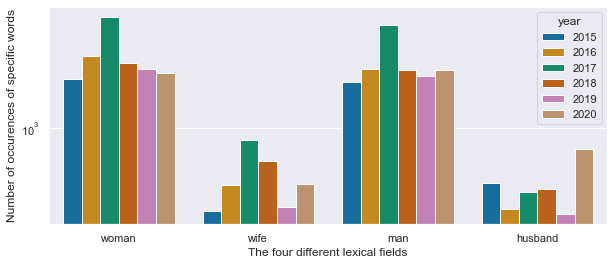

In [34]:
ax = sns.barplot(x =final_lexfield.index, y='sum of number of occurences',hue='year' ,data=final_lexfield)
plt.title('')
plt.xlabel('The four different lexical fields')
plt.ylabel('Number of occurences of specific words')
ax.set(yscale="log");

## Ages of the speaker

In [35]:
quotes_all.shape[0]

698230

In [36]:
quotes_all.describe()

,numOccurrences,age,year
count,698230.000000,698230.000000,698230.000000
mean,3.558809,52.406877,2017.428714
std,34.307046,27.465685,1.591281
min,1.000000,-6.000000,2015.000000
25%,1.000000,38.000000,2016.000000
50%,1.000000,52.000000,2017.000000
75%,2.000000,64.000000,2019.000000
max,25626.000000,2016.000000,2020.000000


In [37]:
quotes_all.drop((quotes_all.loc[(quotes_all.age>100) | (quotes_all.age<1)]).index, 
                inplace=True)
quotes_all.shape[0]

691263

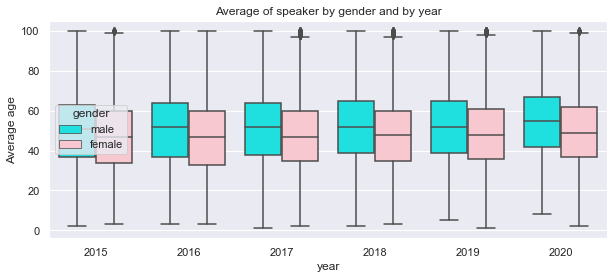

In [38]:
ax = sns.boxplot(x="year",y="age", hue="gender", 
            data=quotes_all.loc[quotes_all['gender'].isin(['male','female'])],
            palette=['cyan','pink']);

ax.set(ylabel='Average age')
ax.set_title('Average of speaker by gender and by year');

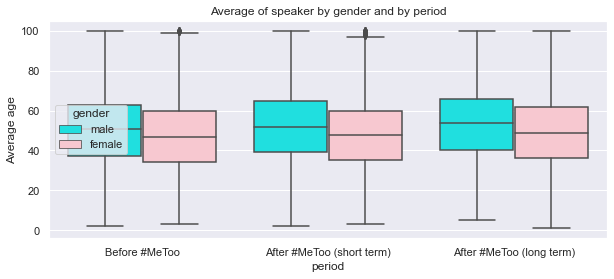

In [39]:
ax = sns.boxplot(x="period", y="age", hue="gender", 
           data=quotes_all.loc[quotes_all['gender'].isin(['male','female'])],
            palette=['cyan','pink'])

ax.set(ylabel='Average age')
ax.set_title('Average of speaker by gender and by period');

## Main occupations represented

In [40]:
df_occupation = quotes_all.get(['occupation','gender']).explode(ignore_index=True, column='occupation')
most_represented_occupation = df_occupation.merge(pd.DataFrame(Counter(df_occupation.occupation)\
                          .most_common(20),columns =['occupation','nb_occurences']), how='right', on='occupation')
most_represented_occupation

,occupation,gender,nb_occurences
0,politician,male,160846
1,politician,male,160846
2,politician,male,160846
3,politician,male,160846
4,politician,male,160846
...,...,...,...
755659,ice hockey player,male,17132
755660,ice hockey player,male,17132
755661,ice hockey player,female,17132
755662,ice hockey player,male,17132


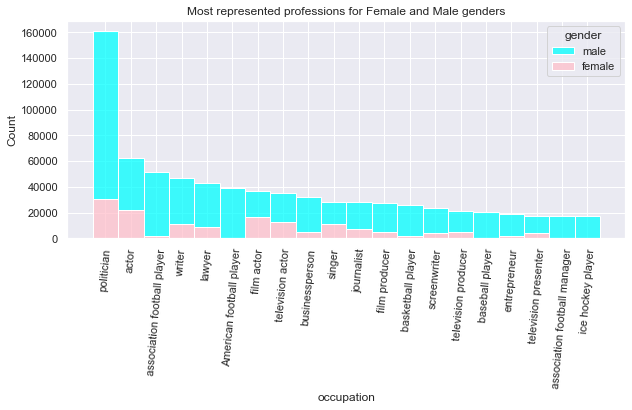

In [41]:
ax = sns.histplot(x="occupation", hue='gender', multiple="stack",
                 data=most_represented_occupation.loc[most_represented_occupation['gender'].isin(['male','female'])], 
                  palette=['cyan','pink'])
ax.set_title('Most represented professions for Female and Male genders')
plt.xticks(rotation=85);

In [42]:
df_occ_female=quotes_all[quotes_all['gender']=='female'].occupation.explode(ignore_index=True)
df_occ_female.shape[0]

309520

In [43]:
df_occ_male=quotes_all[quotes_all['gender']=='male'].occupation.explode(ignore_index=True)
df_occ_male.shape[0]

1245261

In [44]:
most_occ_female=pd.DataFrame(Counter(df_occ_female).most_common(20),columns =['occupation', 'nb_occurences'])
most_occ_female.head()

,occupation,nb_occurences
0,politician,30429
1,actor,22066
2,film actor,16445
3,television actor,12936
4,writer,11526


In [45]:
most_occ_male=pd.DataFrame(Counter(df_occ_male).most_common(20),columns =['occupation', 'nb_occurences'])
most_occ_male.head()

,occupation,nb_occurences
0,politician,130417
1,association football player,50166
2,actor,40045
3,American football player,39149
4,writer,35228


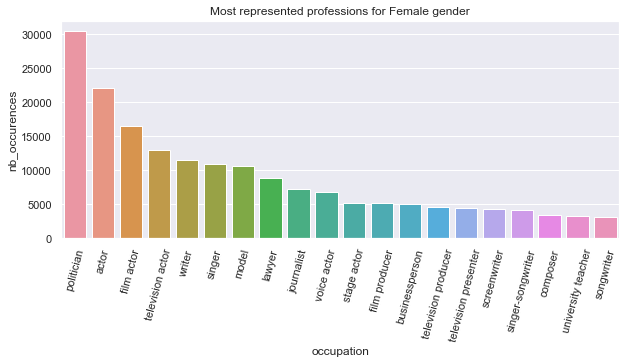

In [46]:
ax = sns.barplot(x='occupation', y='nb_occurences', data=most_occ_female)
ax.set_title('Most represented professions for Female gender')
plt.xticks(rotation=75);

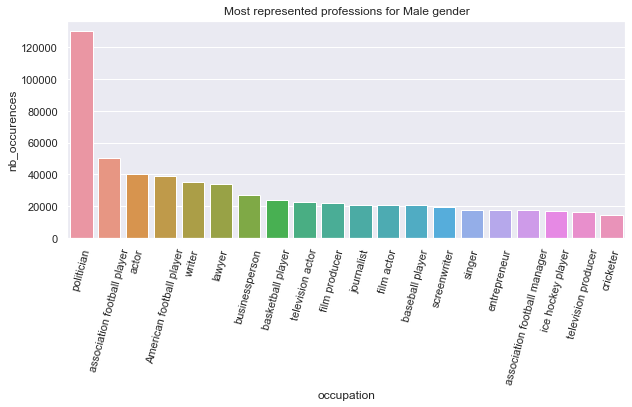

In [47]:
ax = sns.barplot(x='occupation', y='nb_occurences', data=most_occ_male)
ax.set_title('Most represented professions for Male gender')
plt.xticks(rotation=75);